In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [22]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Introduction**

This kernel shows how to classify cats or dogs from images. The zip Dataset contains various images of Cats and Dogs with which I'll use to build an image classifier using a **tf.keras.Sequential model** and load data(data pipline) using **tf.keras.preprocessing.image.ImageDataGenerator**. 

This project workflow includes:

- Examining and understanding the dataset
- Building an input pipeline
- Building the model
- Training a CNN model
- Testing the model
- Graphical representation of the model performance

All these will be done with tensorflow 2.x.

# **Load the Data**

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats')  
validation_dogs_dir = os.path.join(validation_dir, 'dogs') 

# **Overview of the Data**

In [25]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


*There are just 2000 training datasets and 1000 validation datasets*

#**Build an input pipeline**

In [0]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [27]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')



Found 2000 images belonging to 2 classes.


In [28]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### **Visualize the Image**

In [0]:
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

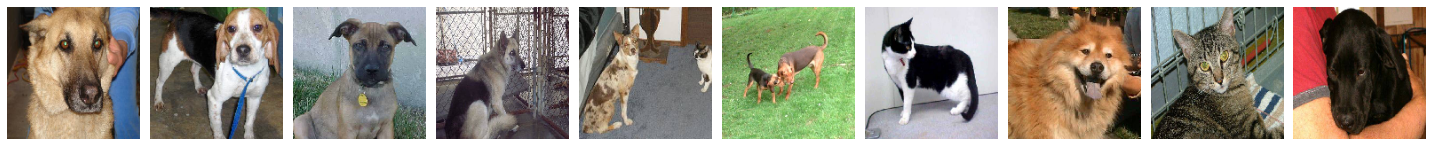

In [30]:
plotImages(sample_training_images[:10])

## **Data augmentation**

- Before I build the model's architecture, from the kernel above we found out that the training example is small compared to datasets usually passed into a Convnet. 

- When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples — to an extent that it negatively impacts the performance of the model on new examples.

- So to avoid overfitting I'll need to augment the dataset so that it has a sufficient or more number of training examples.
  This helps expose the model to more aspects of the data and generalize better.


In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [32]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let me Visualize how a single image would look five different times when passing these augmentations randomly to the dataset

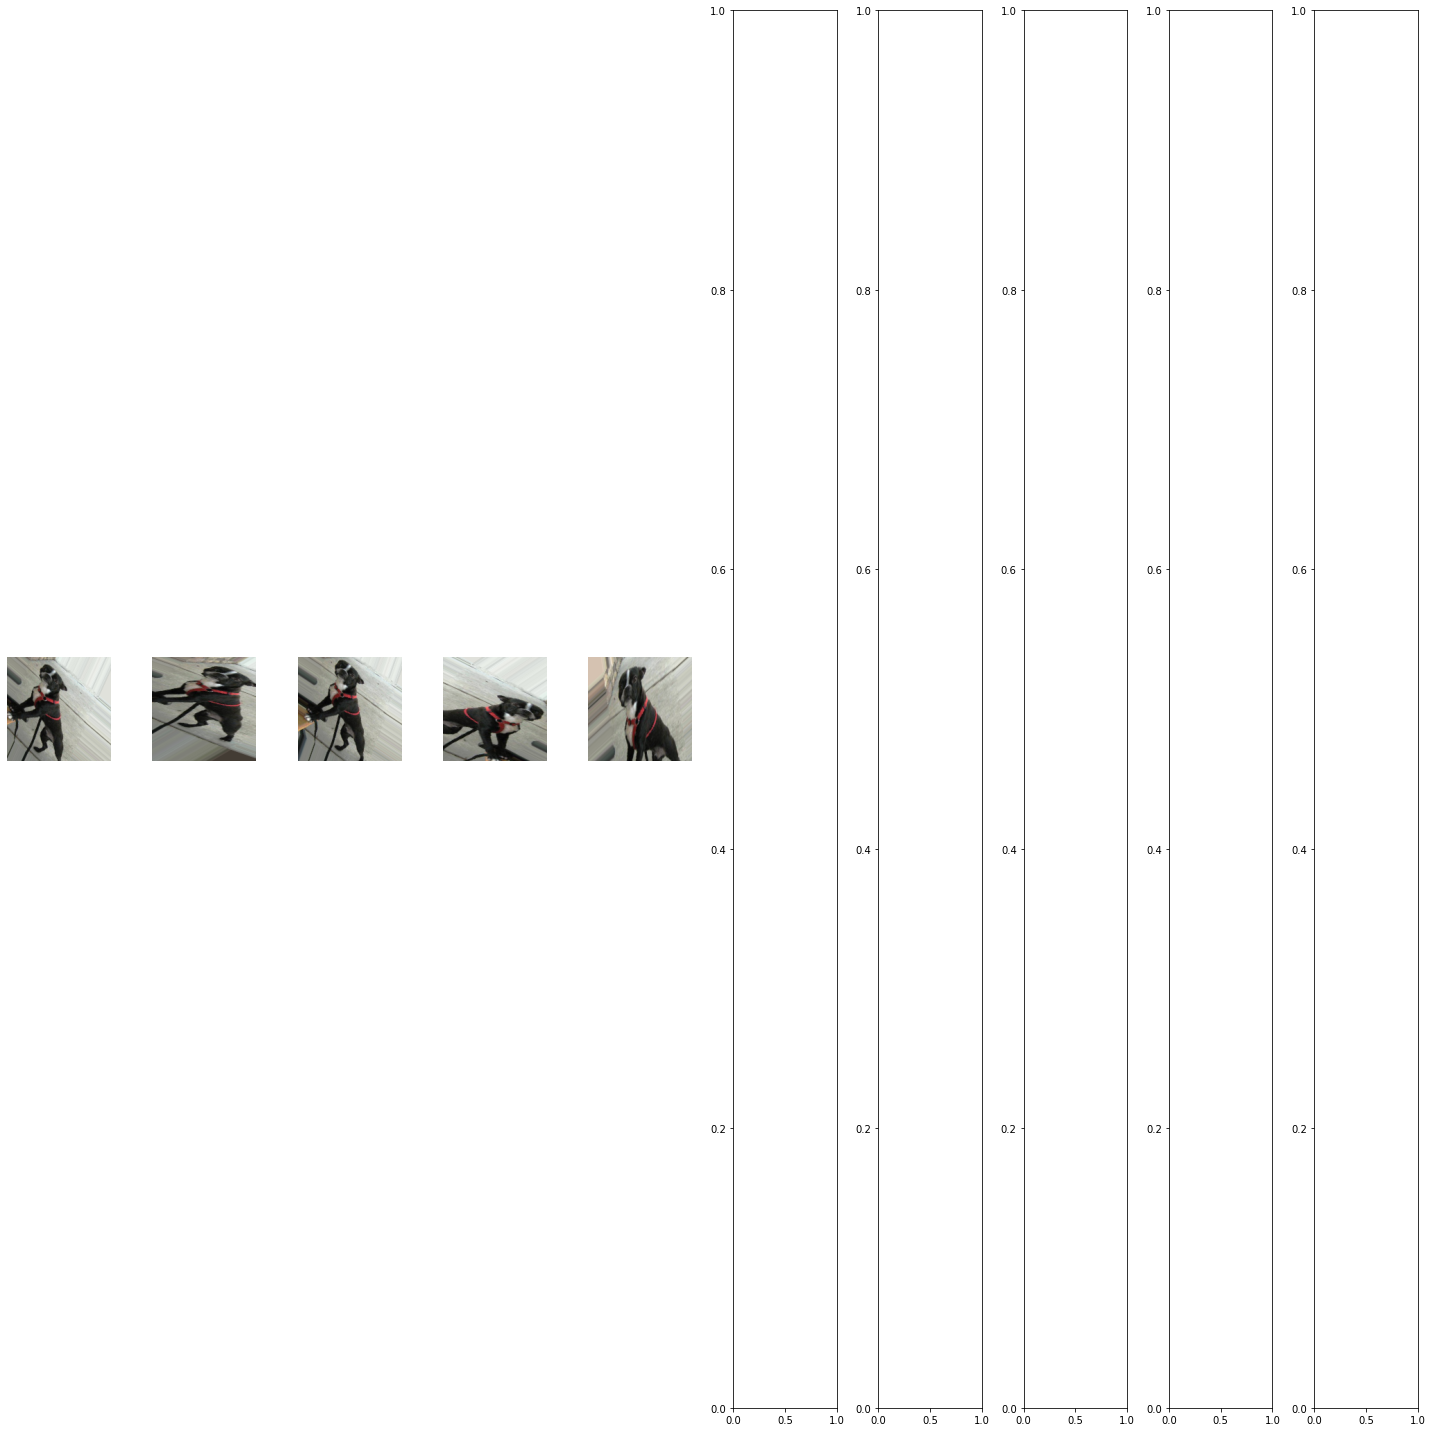

In [33]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [34]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# **Build a CNN Model**

In [0]:
model = Sequential([
    # Block 1
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),

    #Block 2
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),

    #Block 3
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

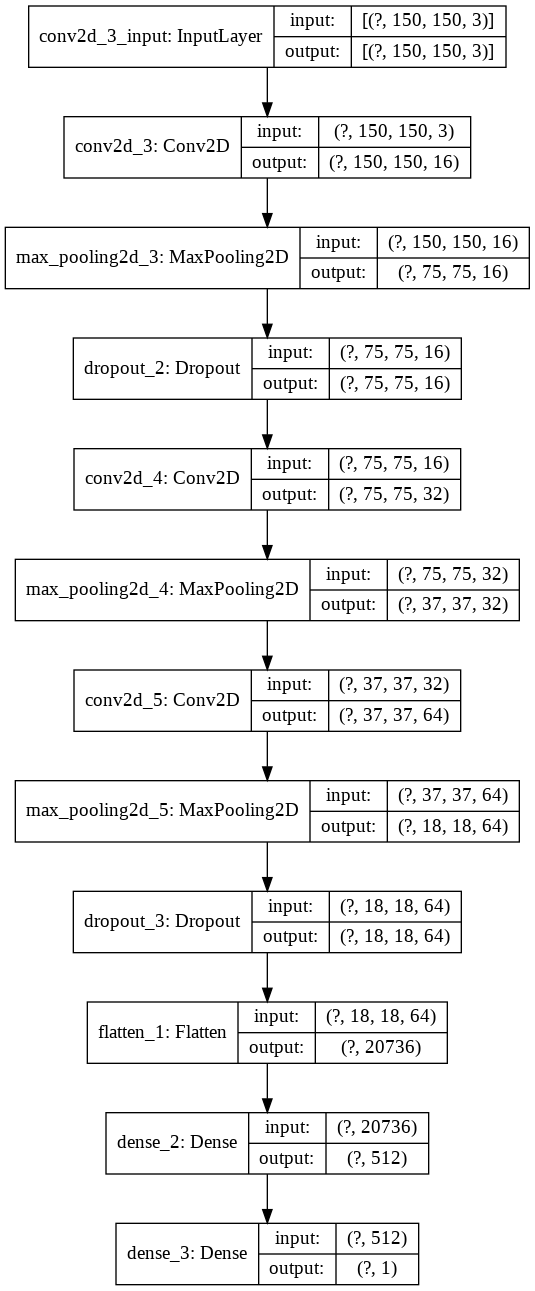

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

# **Train a Model**

In [38]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/100
15/15 [==============================] - 15s 1s/step - loss: 0.8795 - accuracy: 0.4984 - val_loss: 0.6929 - val_accuracy: 0.5022
Epoch 2/100
15/15 [==============================] - 15s 988ms/step - loss: 0.6930 - accuracy: 0.5069 - val_loss: 0.6922 - val_accuracy: 0.5045
Epoch 3/100
15/15 [==============================] - 15s 992ms/step - loss: 0.6930 - accuracy: 0.4899 - val_loss: 0.6917 - val_accuracy: 0.4933
Epoch 4/100
15/15 [==============================] - 15s 980ms/step - loss: 0.6923 - accuracy: 0.5032 - val_loss: 0.6889 - val_accuracy: 0.4989
Epoch 5/100
15/15 [==============================] - 15s 982ms/step - loss: 0.6873 - accuracy: 0.5064 - val_loss: 0.6712 - val_accuracy: 0.5078
Epoch 6/100
15/15 [==============================] - 15s 979ms/step - loss: 0.6831 - accuracy: 0.5075 - val_loss: 0.6679 - val_accuracy: 0.5067
Epoch 7/100
15/15 [==============================] - 15s 977ms/step - loss: 0.6665 - accuracy: 0.5481 - val_loss: 0.6501 - val_accuracy: 0.

### **Visualize the model**


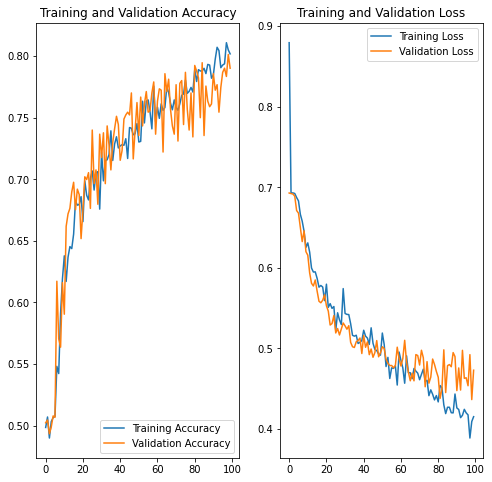

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Predict** 

Populating the interactive namespace from numpy and matplotlib


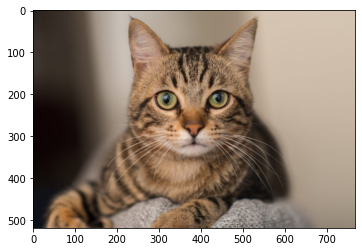

In [64]:
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread('cat.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
import cv2
import numpy as np

def predict(im):
  im = cv2.resize(cv2.imread(im), (150, 150))
  im = im.astype(np.float32)
  im = np.expand_dims(im, axis=0)
  im = im / 255
  out = model.predict(im)
  pred = np.argmax(out)
  if pred == 0:
    return "cat"
  else:
    return "dog" 

In [58]:
cat_image = predict("cat.jpg")
print(cat_image) 

cat
